In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as torchF

class YLoss(nn.Module):
    def __init__(self):
        super(YLoss, self).__init__()

    def forward(self, logits, y):
        loss = nn.CrossEntropyLoss(reduction='mean')(logits, y)
        return loss


class Xloss(nn.Module):
    def __init__(self):
        super(Xloss, self).__init__()

    def forward(self, E, real, fake):
        E_real = torch.mean(E(real))
        E_fake = torch.mean(E(fake))
        loss = -(torch.mean(E_real) - torch.mean(E_fake)) 
        return loss


class SGLD(nn.Module):
    def __init__(self, std, step, init, keep_pr):
        self.init = init
        self.std = std
        self.step = step
        self.init = init
        self.keep_pr = keep_pr
        self.last_samples = []

    def make_init(self, r=0.):
        init = (1 - r) * self.init + r * (2*torch.rand_like(self.init)-1)
        return init
    
    def sample(self, E, n_steps, y=None, clip=False):
        b_size = self.init.size(0)
        r = 1. * (torch.rand(b_size, 1, 1, 1, device=self.init.device) > self.keep_pr)
        init = self.make_init(r)
        x_k = torch.autograd.Variable(init, requires_grad=True)
        for t in range(n_steps):
            grad = torch.autograd.grad(E(x_k, y).sum(), [x_k], retain_graph=True)[0]
            x_k.data += self.step * grad + self.std * torch.randn_like(x_k)
            if clip: x_k.data = torch.clamp(x_k.data, -1., 1.)
        samples = x_k.detach()
        self.init = samples
        return samples

class F(nn.Module):
    def __init__(self, logit_net):
        super(F, self).__init__()
        self.logit_net = logit_net

    def E_un(self, x, y=None):
        logits = self.logit_net(x)
        energy = - torch.logsumexp(logits, 1)
        return energy

    def E_cond(self, x, y):
        logits = self.logit_net(x)
        energy = - logits[:,y]
        return energy


In [2]:
from resnet import wide_basic

class MnistNet(nn.Module):
    def __init__(self, max_h=64, out_size=10):
        super(MnistNet, self).__init__()
        self.conv_seq = nn.Sequential(
            wide_basic(1, 4, 0),
            wide_basic(4, 16, 0),
            wide_basic(16, 32, 0),
            wide_basic(32, 64, 0))
        
        self.linear_seq = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Linear(max_h,  out_size))
    
    def forward(self, x, sum_pool=True):
        x = self.conv_seq(x)
        if sum_pool:
            x = x.view(x.size(0), x.size(1), -1).sum(2)
        else:
            x = torchF.max_pool2d(x, 16)
            x = x.view(x.size(0), -1)
        logits = self.linear_seq(x)
        return logits

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
import numpy as np
def load_mnist(train=True):
    train_dset = datasets.MNIST('datasets', train=train, download=True,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize((0.5,), (0.5,))
                                                             ]))
    return train_dset

In [4]:
from sklearn.metrics import confusion_matrix
def accc(y_hat, y):
    cm = confusion_matrix(y, y_hat)
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1e-5)
    print(np.round(cm.diagonal(),2))

In [5]:
start_gen = -1
def train(dataloader, epoch, lr=1e-4):
    optimizer = optim.Adam(f.parameters(), lr=lr)
    scheduler_lr = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.3)
    for e in range(epoch):
        e_loss = 0
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            logits = f.logit_net(X)
            class_loss = y_loss(logits, y.long())
            
            if e > start_gen:
                f.logit_net.eval()
                fake = sgld.sample(f.E_un, n_steps=20)
                f.logit_net.train()
                gen_loss = x_loss(f.E_un, X, fake)
            else:
                gen_loss = torch.tensor(0.)

            w = 1.
            loss = class_loss + w * gen_loss   
            e_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler_lr.step()
        if e % v_p == 0: 
            print(e, class_loss.item(), gen_loss.item(), e_loss)
            _, y_hat = torch.max(logits.detach(), 1)
            accc(y.cpu().numpy(), y_hat.cpu().numpy())
        
        if (e > start_gen) and (e % v_s) == 0:
            vutils.save_image(fake.detach(), '%s/img_grid/smpl_e%d.png' % (path_f, e))
            
    print('Saving...')
    f.logit_net.eval()
    f.to('cpu')
    torch.save(f.state_dict(), '%s/net_e%d.pth' % (path_f, e))

In [6]:
device = 'cuda:0'

y_loss = YLoss()
x_loss = Xloss()

y_loss.to(device)
x_loss.to(device)

std = 0.01
step = 1.
init = 2*torch.rand((512,784), device=device).reshape(512,1,28,28)-1

keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)

logit_net = MnistNet()
logit_net.to(device)
f = F(logit_net)

epoch = 150

v_p = 5
v_s = 10

In [7]:
import os

path_f = 'mnist_model'
path_img = path_f + '/img_grid'

if os.path.exists(path_f):
    !rm -rf $path_f
    
!mkdir $path_f
!mkdir $path_img

In [8]:
train_points  = load_mnist()
dataloader = torch.utils.data.DataLoader(train_points, batch_size=512, shuffle=True, num_workers=10)

In [9]:
train(dataloader, epoch)

0 5.071349620819092 -0.7556600570678711 2293.0472660064697
[0.   0.5  0.   0.   0.07 0.   0.   0.19 1.   0.  ]
5 2.367933750152588 -1.2414956092834473 128.9620656967163
[0.   0.22 0.   0.11 0.03 0.   0.24 0.   0.   0.  ]
10 2.113489866256714 -0.6176962852478027 157.2734673023224
[0.43 0.37 0.   0.24 0.09 0.   0.15 0.25 0.   0.  ]
15 2.183886766433716 -1.5650289058685303 149.21234118938446
[0.15 0.54 0.   0.   0.   0.   0.18 0.19 0.36 0.  ]
20 2.220238447189331 -0.7493013143539429 165.10277378559113
[0.14 0.24 0.56 0.12 0.06 1.   0.25 0.43 0.   0.12]
25 2.081840991973877 -0.34919512271881104 163.74372136592865
[0.5  0.5  0.5  0.33 0.07 0.   0.33 0.5  0.33 0.22]
30 1.9435807466506958 -0.5979659557342529 159.87365627288818
[1.   0.7  0.36 0.   0.14 0.37 0.33 0.2  0.   0.5 ]
35 1.8404189348220825 -0.6459789276123047 153.1169354915619
[0.83 0.92 1.   0.54 0.   0.5  0.2  0.5  0.   0.25]
40 1.8267143964767456 -0.5190324783325195 150.65553867816925
[0.41 0.71 0.33 0.6  0.   0.58 0.67 0.6  0.  

# Unconditional sampling from JEM training

In [10]:
f.to('cuda:0');

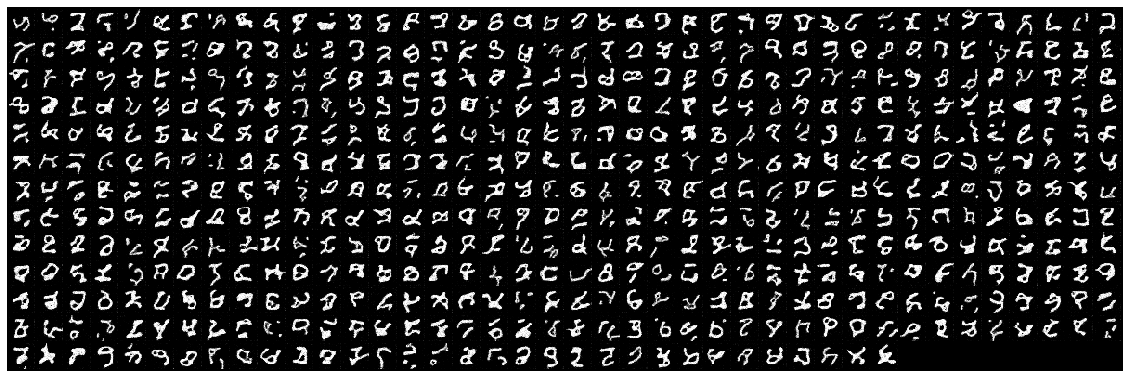

In [116]:
std = 0.1
step = 1.
init = 2*torch.rand((512,784), device=device).reshape(512,1,28,28)-1

keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)
fake = sgld.sample(f.E_un, 100, y=None, clip=True)

plt.figure(figsize=(20,10))
grid_img = vutils.make_grid(0.5*(fake.cpu()+1), nrow=40)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

In [91]:
init, _ = next(iter(dataloader))

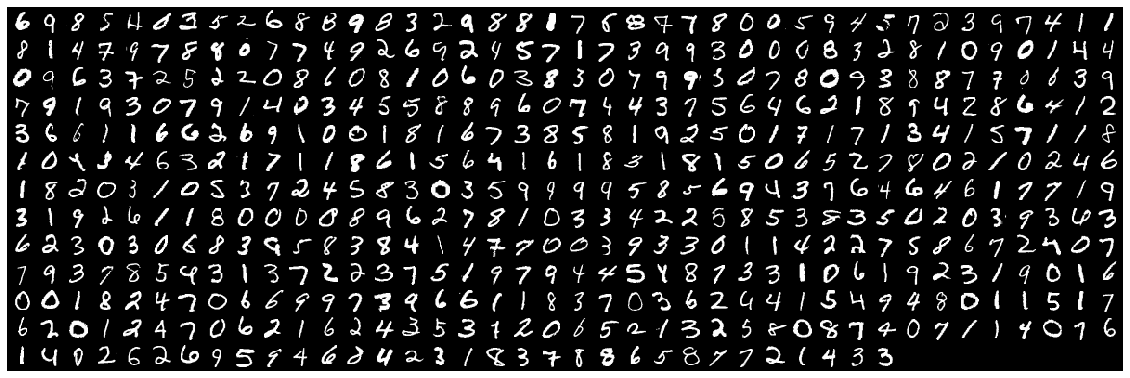

In [92]:
plt.figure(figsize=(20,10))
grid_img = vutils.make_grid(0.5*(init.cpu()+1), nrow=40)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

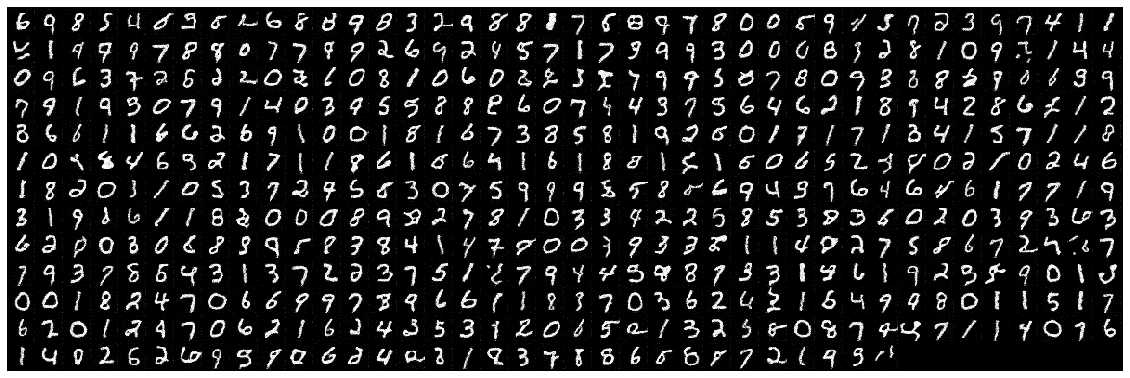

In [97]:
std = 0.1
step = 1

keep_pr = 0.95

sgld = SGLD(std, step, init.to('cuda:0'), keep_pr)
fake = sgld.sample(f.E_un, 100, y=None, clip=True)

plt.figure(figsize=(20,10))
grid_img = vutils.make_grid(0.5*(fake.cpu()+1), nrow=40)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

# Conditional sampling from JEM training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


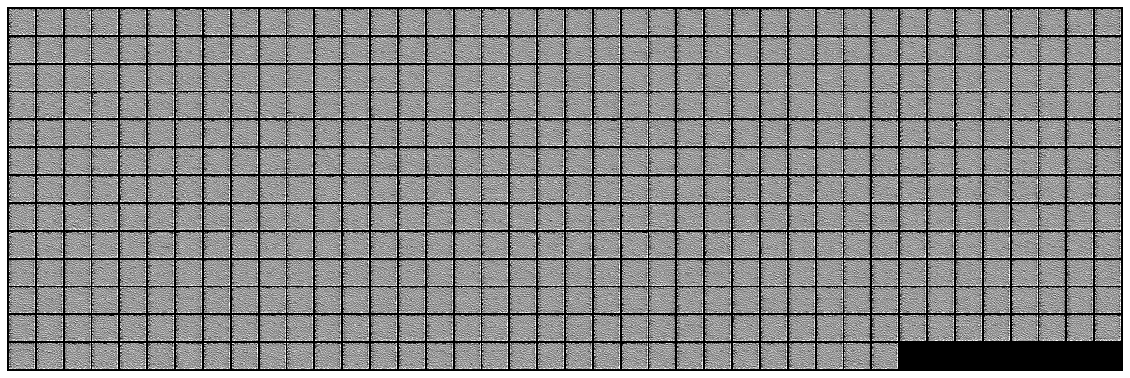

In [98]:
std = 0.01
step = 1.
init = 2*torch.rand((512,784), device=device).reshape(512,1,28,28)-1

keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)
fake = sgld.sample(f.E_cond, 20, y=0, clip=False)

plt.figure(figsize=(20,10))
grid_img = vutils.make_grid(0.5*(fake.cpu()+1), nrow=40)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

In [99]:
init, y = next(iter(dataloader))
init = init[y==9]

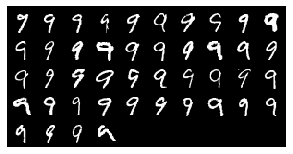

In [100]:
plt.figure(figsize=(5,5))
grid_img = vutils.make_grid(0.5*(init.cpu()+1), nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

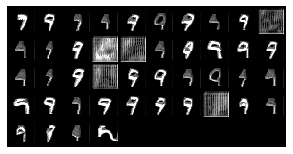

In [115]:
std = 0.01
step = 5.


keep_pr = 0.95

sgld = SGLD(std, step, init.to('cuda:0'), keep_pr)
fake = sgld.sample(f.E_cond, 100, y=9, clip=True)

plt.figure(figsize=(5,5))
grid_img = vutils.make_grid(0.5*(fake.cpu()+1), nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');